In [14]:
import pandas as pd
import numpy as np

# import file
df = pd.read_csv('../../res/tp2/german_credit.csv', sep=',') # columns: admit, gre, gpa, rank; 399 rows
#df = df[['Creditability', 'Account Balance', 'Duration of Credit (month)', 'Credit Amount', 'Age (years)']]

In [15]:
all_attrs = set(df)
all_attrs.remove('Creditability')

continuous_attrs = {'Duration of Credit (month)': ['<= 12', '<= 24', '<= 36', '<= 48', '<= 60', '> 60'],
                    'Credit Amount': ['<= 1000', '<= 2000', '<= 3000', '<= 4000', '<= 5000', '<= 6000', '<= 7000', '<= 8000',
                                      '<= 9000', '<= 10000', '<= 12000', '<= 14000', '> 14000'],
                    'Age (years)': ['< 30', '< 60', '>= 60']}
discrete_attrs = dict(map(lambda attr_name: (attr_name, list(df[attr_name].unique())),
                          filter(lambda attr_name: attr_name not in continuous_attrs, all_attrs)
                         ))
print(all_attrs)
print(list(discrete_attrs.keys()))

{'No of dependents', 'No of Credits at this Bank', 'Value Savings/Stocks', 'Telephone', 'Age (years)', 'Type of apartment', 'Duration in Current address', 'Sex & Marital Status', 'Payment Status of Previous Credit', 'Length of current employment', 'Occupation', 'Concurrent Credits', 'Duration of Credit (month)', 'Credit Amount', 'Instalment per cent', 'Guarantors', 'Foreign Worker', 'Account Balance', 'Most valuable available asset', 'Purpose'}
['No of dependents', 'No of Credits at this Bank', 'Value Savings/Stocks', 'Telephone', 'Type of apartment', 'Duration in Current address', 'Sex & Marital Status', 'Payment Status of Previous Credit', 'Length of current employment', 'Occupation', 'Concurrent Credits', 'Instalment per cent', 'Guarantors', 'Foreign Worker', 'Account Balance', 'Most valuable available asset', 'Purpose']


In [16]:
from sklearn.model_selection import train_test_split

# Separar los datos en datos de entrenamiento y testeo
train, test = train_test_split(df, test_size=0.2)

test.head()

,Creditability,Account Balance,Duration of Credit (month),Payment Status of Previous Credit,Purpose,Credit Amount,Value Savings/Stocks,Length of current employment,Instalment per cent,Sex & Marital Status,...,Duration in Current address,Most valuable available asset,Age (years),Concurrent Credits,Type of apartment,No of Credits at this Bank,Occupation,No of dependents,Telephone,Foreign Worker
852,0,2,24,4,9,1935,1,5,4,1,...,4,1,31,3,2,2,3,1,2,1
972,0,3,18,2,3,2100,1,3,4,3,...,2,1,37,3,2,1,3,1,1,1
989,0,2,24,2,0,2718,1,3,3,2,...,4,2,20,3,1,1,2,1,2,1
351,1,4,24,2,0,1525,4,4,4,2,...,3,3,34,3,2,1,3,2,2,1
88,1,1,6,4,0,666,4,4,3,2,...,4,1,39,3,2,2,2,1,2,1


In [17]:
import math

global entropy
entropy = None
positive_creditability = 'Creditability == 1'

def format_query_string(attr, value, index=-1):
    if attr in continuous_attrs:
        return f'not (`{attr}` {continuous_attrs[attr][index-1]}) and `{attr}` {value}' if index > 0 else f'`{attr}` {value}'
    
    return f'`{attr}` == {value}'

def get_entropy_term(p):
    return - p * math.log2(p) if not math.isclose(p, 0) else 0

def get_entropy(data, cond=positive_creditability): # H(S)
    positive_freq = len(data.query(cond)) / len(data) if len(data) != 0 else 0
    negative_freq = 1 - positive_freq if len(data) != 0 else 0
    entropy = get_entropy_term(positive_freq) + get_entropy_term(negative_freq)
    
    return entropy

def get_attr_entropy(data, cond): # H(Sv)
    positive_freq = len(data.query(cond)) / len(data) if len(data) != 0 else 0
    negative_freq = 1 - positive_freq if len(data) != 0 else 0
    return get_entropy_term(positive_freq) + get_entropy_term(negative_freq)

def get_rows_by_attr_cond(data, attr, cond, cond_index):
    rows = None
    
    if cond_index == 0:
        rows = data.query(f'`{attr}` {cond}')
    else:
        prev_cond = continuous_attrs[attr][cond_index-1]
        rows = data.query(f'not(`{attr}` {prev_cond}) and `{attr}` {cond}')
        
    return rows
    
def gain(data, attr, class_cond=positive_creditability):
    ret = get_entropy(data)
    
    if attr in continuous_attrs:
        for i, cond in enumerate(continuous_attrs[attr]):
            rows = get_rows_by_attr_cond(data, attr, cond, i)
            ret -= len(rows) / len(data) * get_attr_entropy(rows, class_cond)
            # print(f'{attr}: {ret}')
    else:
        for value in discrete_attrs[attr]: # TODO FIX: PREGUNTAR SI VALOR DE ATRIBUTO NO APARECE EN TRAIN, FALLA
            rows = data.query(f'`{attr}` == {value}')
            ret -= len(rows) / len(data) * get_attr_entropy(rows, class_cond)
            # print(f'{attr},{value}: {ret}')
    
    return ret

gains = {}
for attr in train.columns:
    if attr == 'Creditability':
        continue
    gains[attr] = gain(train, attr)

print(gains)

#df['Credit Amount'].hist(grid=True, bins=30, rwidth=0.9, color='#607c8e')
#print(get_entropy(train, train.Creditability == 1))

{'Account Balance': 0.09653078668745184, 'Duration of Credit (month)': 0.02663748988727329, 'Payment Status of Previous Credit': 0.05329465436545453, 'Purpose': 0.027228030571185002, 'Credit Amount': 0.024211960071644882, 'Value Savings/Stocks': 0.020371923940529262, 'Length of current employment': 0.015674476305784585, 'Instalment per cent': 0.005084027694970475, 'Sex & Marital Status': 0.0049973989604388674, 'Guarantors': 0.00141324800069198, 'Duration in Current address': 0.0023585326748890717, 'Most valuable available asset': 0.018573244691512003, 'Age (years)': 0.01218388662362127, 'Concurrent Credits': 0.008237410367246858, 'Type of apartment': 0.018786780151369697, 'No of Credits at this Bank': 0.002407439231729488, 'Occupation': 0.0009400802646661877, 'No of dependents': 1.4053974337596697e-05, 'Telephone': 0.0009743247882532113, 'Foreign Worker': 0.004666945391323847}


In [27]:
from tree import Tree, NodeType
import pdb

def get_max_gain(gains):
    max_attr = None
    max_gain = -1
    for attr, gain in gains.items():
        if gain > max_gain:
            max_gain = gain
            max_attr = attr
    return max_attr, max_gain

used_attrs = set({})

def add_level(data, current_level_attr, node=None, stdout=False):
    global used_attrs
    
    tree = None
    current_level_attr_node = None
    if node is None:
        tree = Tree()
        tree.root = current_level_attr_node = Tree.Node(NodeType.attr, current_level_attr)
    else:
        current_level_attr_node = node.add_child(NodeType.attr, current_level_attr)
    
    used_attrs.add(current_level_attr)
    
    values = continuous_attrs[current_level_attr] if current_level_attr in continuous_attrs else discrete_attrs[current_level_attr]
    for i, val in enumerate(values):
        
        if tree is not None and stdout:
            print(f'Processing value {val} for root attribute {tree.root.value}...')
        
        current_level_attr_value_node = current_level_attr_node.add_child(NodeType.val, val)
        rows = data.query(format_query_string(current_level_attr, val, i))
        
        if (len(rows) == 0):
            current_level_attr_value_node.add_child(NodeType.leaf, data['Creditability'].mode()[0])
            continue
        
        classes = rows['Creditability'].unique()
        if len(classes) == 1:  # Only positive or negative examples left (leaf)
            current_level_attr_value_node.add_child(NodeType.leaf, classes[0])
            continue
        else:
            selected_attrs = set(data) - set(['Creditability'])
            unprocessed_attrs = selected_attrs - used_attrs # Selected dataset columns - Used columns
            if len(unprocessed_attrs) == 0:  # No more attributes to calculate gain for (leaf)
                current_level_attr_value_node.add_child(NodeType.leaf, rows['Creditability'].mode()[0])  # The most frequent value for Creditability
            else:
                current_gains = {}
                for attr in unprocessed_attrs:
                    current_gains[attr] = gain(rows, attr)
                next_level_attr, _ = get_max_gain(current_gains)
                # print(current_gains)
                if (next_level_attr is None):
                    raise Exception(f'Invalid state: gains returned attribute None - {current_gains}')
                else:
                    add_level(rows, next_level_attr, current_level_attr_value_node)
    
    used_attrs.remove(current_level_attr)
    
    if tree:
        used_attrs.clear()
        return tree


#tr = Tree(root_attr)
#add_level(train, root_attr, tr.root)
#print('\n\n\n\n\n**********************************\n\n\n')
#print(tr)

In [28]:
def evaluate_condition(attr, asked_value, tree_cond): # attr = Age, asked_value = 28, tree_cond = '<= 30'
    if attr in continuous_attrs:
        index = continuous_attrs[attr].index(tree_cond)
        return eval(f'not ({asked_value} {continuous_attrs[attr][index-1]}) and {asked_value} {tree_cond}' if index > 0 else f'{asked_value} {tree_cond}')
        
    return asked_value == tree_cond

def classify(row, tree, stdout=False):
    current_node = tree.root
    current_node_type = NodeType.attr
    
    while(current_node.children):
        current_node_val = current_node.value
        current_node_type = current_node.node_type
        if stdout:
            print(f'Node value: {current_node_val} - Type: {current_node_type}')
        
        if current_node_type == NodeType.attr:
            row_val = row[current_node_val]
            found_value = False
            for child in current_node.children:
                # print(f'Attr {current_node_val} Child Value: {child.value}')
                if evaluate_condition(current_node_val, row_val, child.value):
                    current_node = child
                    found_value = True
                    break
            if not found_value:
                raise Exception('Could not find attribute value')
        elif current_node_type == NodeType.val:
            current_node = current_node.children[0]
        else:
            raise Exception('Invalid State')
    
    if stdout:
        print(f'\nNode value: {current_node.value} - Type: {current_node_type}\n')
    return current_node.value

def build_tree(data, stdout=False):
    root_gains = {}
    for attr in data.columns:
        if attr == 'Creditability':
            continue
        root_gains[attr] = gain(data, attr)
    
    root_attr, _ = get_max_gain(root_gains)
    if (root_attr is None):
        raise Exception(f'Invalid state: gains returned attribute None - {root_gains}')
    
    tree = add_level(data, root_attr, stdout=stdout)
    if stdout:
        print(tree)
    return tree

# print(test.iloc[0])
# classify(test.iloc[0], tree)

In [29]:
import statistics as stats
from random import sample

# Bagging - Random forest
def build_forest(data, sample_fraction=0.4, iterations=3, column_sample_size=len(all_attrs), stdout=False):
    forest = []
    selected_columns = list(all_attrs)
    selected_columns.append('Creditability')
    
    while iterations > 0:
        print(f'Remaining trees: {iterations}')
        
        if column_sample_size != len(all_attrs):
            selected_columns = sample(all_attrs, column_sample_size)
            if 'Creditability' not in selected_columns:
                selected_columns.append('Creditability')
            
        subset = data.sample(frac=sample_fraction, replace=True, axis=0)
        t = build_tree(subset[selected_columns], stdout=stdout)
        forest.append(t)
        iterations -= 1
        
        #print(f'\n\n\n\n\n\n\n\n************STARTING TREE************\n\n\n\n\n\n\n\n{t}')
        
    print('Done\n')
    return forest

def classify_random_forest(row, data=train, forest=None, stdout=False):
    if forest is None:
        forest = build_forest(data, stdout=stdout)
    classifications = []
    for tree in forest:
        classifications.append(classify(row, tree, stdout))
    if stdout:
        print(classifications)
    return stats.mode(classifications)

In [9]:
row = test.iloc[0]
print(row)
print(classify_random_forest(row, stdout=True))

Remaining trees: 9
Processing value 1 for root attribute Account Balance...
Processing value 2 for root attribute Account Balance...
Processing value 4 for root attribute Account Balance...
Processing value 3 for root attribute Account Balance...
Remaining trees: 8
Processing value 1 for root attribute Account Balance...
Processing value 2 for root attribute Account Balance...
Processing value 4 for root attribute Account Balance...
Processing value 3 for root attribute Account Balance...
Remaining trees: 7
Processing value 1 for root attribute Account Balance...
Processing value 2 for root attribute Account Balance...
Processing value 4 for root attribute Account Balance...
Processing value 3 for root attribute Account Balance...
Remaining trees: 6
Processing value 1 for root attribute Account Balance...
Processing value 2 for root attribute Account Balance...
Processing value 4 for root attribute Account Balance...
Processing value 3 for root attribute Account Balance...
Remaining tr

<AxesSubplot:>

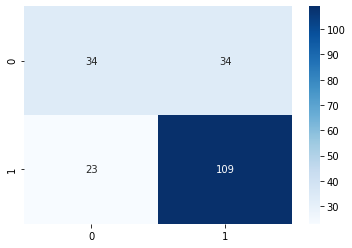

In [63]:
import seaborn as sns

# Armado de matriz de confusión (filas: valores reales; columnas: valores predictivos)
confusion_matrix = { 0: {}, 1: {} }
columns = []
for key in confusion_matrix.keys():
    columns.append(key)
    confusion_matrix[key] = { 0: 0, 1: 0 } # {0: {0: 700, 1: 1048}, 1: {...}}

forest = build_forest(train, sample_fraction=0.6, iterations=9)
for i in range(len(test)):
    row = test.iloc[i]
    creditability = row['Creditability']
    
    result = classify_random_forest(row, forest=forest)
    confusion_matrix[creditability][result] += 1

confusion_df = { key : list(confusion_matrix[key].values()) for key in confusion_matrix.keys() }
confusion_df = pd.DataFrame.from_dict(confusion_df, orient='index', columns=columns)

sns.heatmap(confusion_df, annot=True, cmap='Blues', fmt='g')

In [64]:
print(test['Creditability'].value_counts())

1    132
0     68
Name: Creditability, dtype: int64


In [33]:
def get_precision_plot(data, stdout=False):
    column_count = len(all_attrs)
    plot_points = []
    
    for i in range(3, column_count + 1):
        if stdout:
            print(f'Generating results using {i} attributes...')
            
        forest = build_forest(data, column_sample_size=i, iterations=9, stdout=False)
        
        correct_classifications = 0
        for index, row in data.iterrows():
            classification = classify_random_forest(row, forest=forest)
            if classification == row['Creditability']:
                correct_classifications += 1
        
        plot_points.append(correct_classifications / len(data))
    
    if stdout:
        print(plot_points)
    
    return plot_points

test_precisions = get_precision_plot(test, True)
train_precisions = get_precision_plot(train, True)
plot = pd.DataFrame({'test': test_precisions, 'train': train_precisions}, index=[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
lines = plot.plot.line()

Generating results using 3 attributes...
Remaining trees: 9
Remaining trees: 8
Remaining trees: 7
Remaining trees: 6
Remaining trees: 5
Remaining trees: 4
Remaining trees: 3
Remaining trees: 2
Remaining trees: 1
Done

Generating results using 4 attributes...
Remaining trees: 9
Remaining trees: 8
Remaining trees: 7
Remaining trees: 6
Remaining trees: 5
Remaining trees: 4
Remaining trees: 3
Remaining trees: 2
Remaining trees: 1
Done

Generating results using 5 attributes...
Remaining trees: 9
Remaining trees: 8
Remaining trees: 7
Remaining trees: 6
Remaining trees: 5
Remaining trees: 4
Remaining trees: 3
Remaining trees: 2
Remaining trees: 1
Done

Generating results using 6 attributes...
Remaining trees: 9
Remaining trees: 8
Remaining trees: 7
Remaining trees: 6
Remaining trees: 5
Remaining trees: 4
Remaining trees: 3
Remaining trees: 2
Remaining trees: 1
Done

Generating results using 7 attributes...
Remaining trees: 9
Remaining trees: 8
Remaining trees: 7
Remaining trees: 6
Remaining t

TypeError: no numeric data to plot

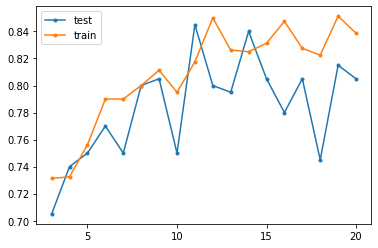

In [39]:
# Forest size = 3
df = pd.DataFrame({'test': [0.705, 0.74, 0.75, 0.77, 0.75, 0.8, 0.805, 0.75, 0.845, 0.8, 0.795, 0.84, 0.805, 0.78, 0.805, 0.745, 0.815, 0.805], 'train': [0.73125, 0.7325, 0.75625, 0.79, 0.79, 0.8, 0.81125, 0.795, 0.8175, 0.85, 0.82625, 0.825, 0.83125, 0.8475, 0.8275, 0.8225, 0.85125, 0.83875]}, index=[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
lines = df.plot.line(style='.-')
lines.locator_params(integer=True)

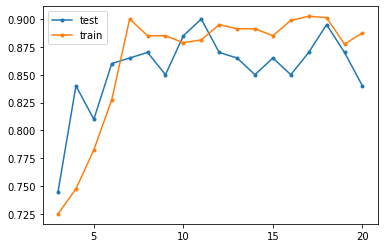

In [37]:
# Forest size = 9
df = pd.DataFrame({'test': [0.745, 0.84, 0.81, 0.86, 0.865, 0.87, 0.85, 0.885, 0.9, 0.87, 0.865, 0.85, 0.865, 0.85, 0.87, 0.895, 0.87, 0.84], 'train': [0.725, 0.7475, 0.7825, 0.8275, 0.9, 0.885, 0.885, 0.87875, 0.88125, 0.895, 0.89125, 0.89125, 0.885, 0.89875, 0.9025, 0.90125, 0.8775, 0.8875]}, index=[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])
lines = df.plot(style='.-')
lines.locator_params(integer=True)